In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader 

from torchvision import transforms 

In [2]:
df = pd.read_csv('~/data/digit-recognizer/train.csv')
df_test = pd.read_csv('~/data/digit-recognizer/test.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Train-test split and converting to torch.Tensor

X = df.iloc[:, 1:].values.reshape((-1,1,28,28))
y = df.iloc[:, 0].values

# X = X[:1000]
# y = y[:1000]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80)
X_train, y_train, X_val, y_val = map(
    torch.tensor, (X_train, y_train, X_val, y_val)
)

# Convert from tensor.Long to tensor.Float
X_train = X_train.float()
X_val = X_val.float()

X_test = df_test.values.reshape((-1,1,28,28))
X_test = torch.tensor(X_test).float()

X_test = X_test[:100]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_test.shape)

torch.Size([33600, 1, 28, 28]) torch.Size([33600]) torch.Size([8400, 1, 28, 28]) torch.Size([8400])
torch.Size([100, 1, 28, 28])


In [8]:
def show_random_digits(X, y):
    # Show some images
    fig = plt.figure(figsize=(10,10))
    colsize = 3
    rowsize = 3
    for i in range(1, colsize*rowsize +1):
        fig.add_subplot(colsize, rowsize, i)
        num = np.random.randint(0, len(X))
        plt.title(str(y[num].item()))
        plt.imshow(X[num].resize(28,28))

    plt.show()

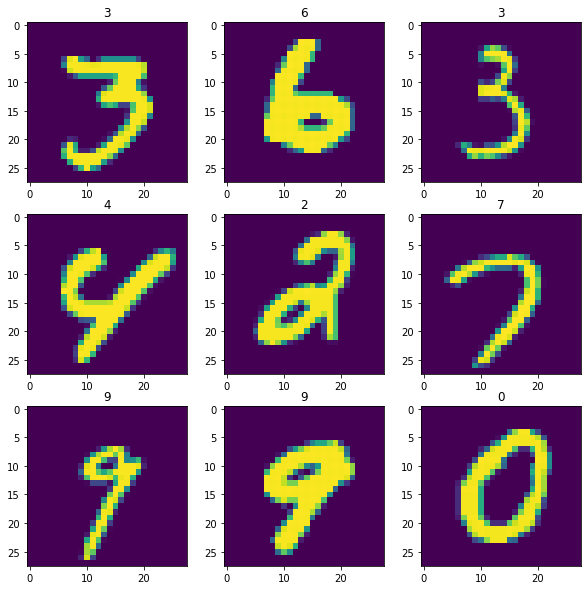

In [9]:
show_random_digits(X_train, y_train)

In [10]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [11]:
# Input (N images) N x 1 x 28 x 28  (1 channel (grayscale))
# Output N x 2
model = torch.nn.Sequential(
    # N x 1 x 28 x 28
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
    # N x 32 x 26 x 26
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    # N x 32 x 13 x 13
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
    # N x 64 x 11 x 11
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    # N x 64 x 5 x 5
    Flatten(),
    # N x 1600
    torch.nn.Linear(1600, 512),
    # N x 512
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 10),
    # N x 10
    torch.nn.Sigmoid(),
    # N x 10
    torch.nn.Softmax(dim = 1)
)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [12]:
# Create combined dataset

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

# Create dataloader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)

In [9]:
# Train
def train(load_model = False):
    if load_model:
        model.load_state_dict(torch.load('../models/mnist.pth'))
        model.eval()
        print('Model loaded')
    
    train_accs = np.empty(0)
    val_accs = np.empty(0)
    epochs = 5
    tot_itr = 2000
    for epoch in range(epochs):
        print('Epoch == ', epoch)
        for X, Y in train_dl:
            yhat = model(X)
            # yhat: N x 10
            # Y: N
            loss = criterion(yhat, Y)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()

        # Calculate accuracy at the end of each epoch
        pred = torch.argmax(model(X_train), dim = 1).data
        train_acc = metrics.accuracy_score(pred, y_train)
        
        pred = torch.argmax(model(X_val), dim = 1).data
        val_acc = metrics.accuracy_score(pred, y_val)
        
        train_accs = np.append(train_accs, train_acc)
        val_accs = np.append(val_accs, val_acc)
        print('Accuracy train', train_acc, 'Accuracy val:', val_acc)
    
    # Save the trained model
    torch.save(model.state_dict(), '../models/mnist.pth')
    print('Model saved')
    
    plt.xlabel('Epochs')
    plt.ylim(0, 1)
    plt.plot(np.arange(len(train_accs)), train_accs, label='Training Accuracy')
    plt.plot(np.arange(len(val_accs)), val_accs, label='Validation Accuracy')
    plt.legend()
    plt.show()

In [13]:
def test():
    # Load the model
    model.load_state_dict(torch.load('../models/mnist.pth'))
    model.eval()
    print('Model loaded')
    
    y_pred = torch.argmax(model(X_test), dim = 1)
    return y_pred

In [14]:
def show_first_layer_weights():
    # Load the model
    model.load_state_dict(torch.load('../models/mnist.pth'))
    model.eval()
    print('Model loaded')
    
    # Show some filters
    fig = plt.figure(figsize=(10,10))
    colsize = 8
    rowsize = 4
    for i in range(1, min(colsize*rowsize, model[0].weight.shape[0]) + 1):
        fig.add_subplot(colsize, rowsize, i)
        plt.imshow(model[0].weight[i-1][0].data.numpy())

    plt.show()

In [15]:
def get_incorrect(X, y, pred):
    df_inc = pd.DataFrame({'indices': np.arange(len(y)), 'y': y, 'p': pred})
    df_inc = df_inc[df_inc['y'] != df_inc['p']]
    return df_inc['indices'].values    

In [ ]:
train(False)

Epoch ==  0


/home/shashwat/Applications/pytorch/torch/csrc/utils/python_arg_parser.cpp:698: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, Number alpha)
  TORCH_WARN_ONCE(msg);


Model loaded
torch.Size([100, 1, 28, 28]) torch.Size([100])


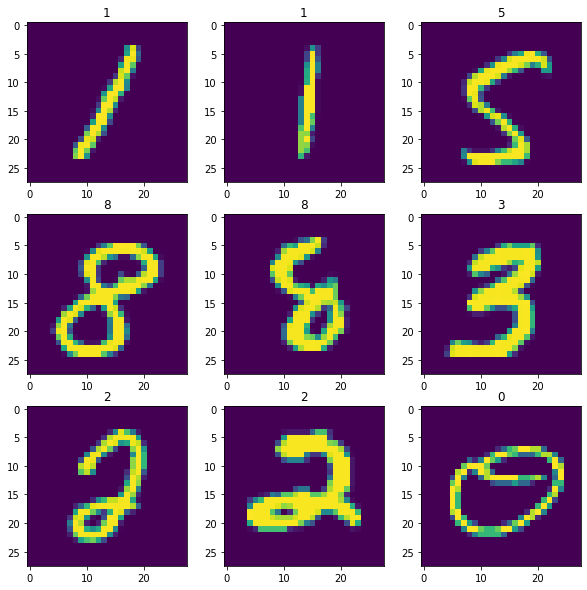

In [19]:
# Show some predictions

pred = test()
print(X_test.shape, pred.shape)
show_random_digits(X_test, pred)

Accuracy val 0.9989285714285714


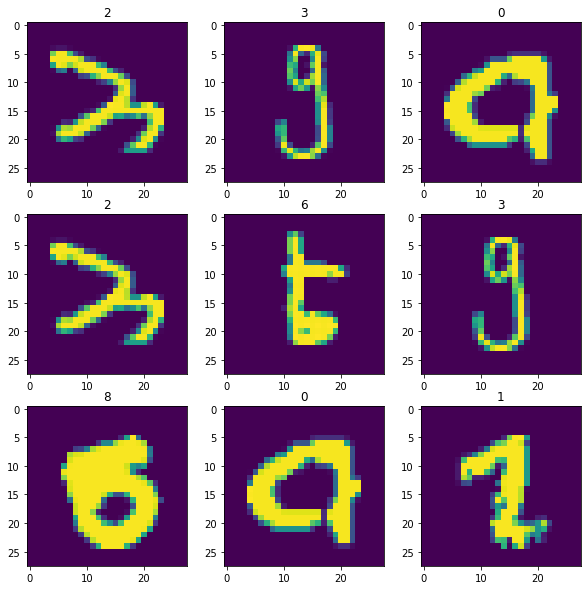

In [20]:
# Check incorrect predictions in validation set
pred = torch.argmax(model(X_val), dim = 1).data
print('Accuracy val', metrics.accuracy_score(pred, y_val))
ind = get_incorrect(X_val, y_val, pred)
show_random_digits(X_val[ind], pred[ind])

Model loaded


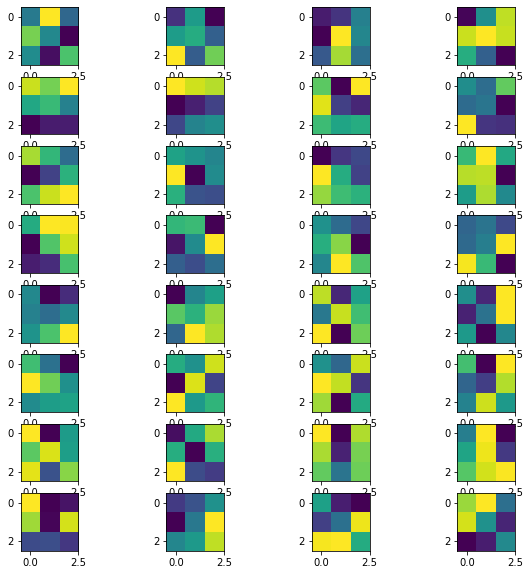

In [21]:
show_first_layer_weights()

In [13]:
X_test.shape

torch.Size([100, 1, 28, 28])

In [43]:
df_out = pd.DataFrame({'ImageID': np.arange(pred.size()[0]) + 1, 'Label': pred.data})
df_out.head()
df_out.set_index('ImageID', inplace=True)
df_out.to_csv('mnist_out.csv')

In [40]:
pred.data

tensor([2, 0, 9, 9, 3, 9, 0, 3, 0, 3, 5, 9, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5,
        9, 4, 2, 9, 4, 9, 9, 5, 4, 2, 9, 2, 5, 5, 1, 0, 9, 9, 4, 9, 8, 3, 8, 2,
        0, 3, 9, 8, 8, 3, 8, 2, 1, 2, 4, 0, 4, 1, 9, 0, 0, 0, 1, 9, 0, 1, 9, 5,
        8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 9, 9, 2, 0, 9, 9, 1, 4,
        3, 9, 9, 4])